In [5]:
import open3d as o3d
import numpy as np
import json
from pathlib import Path
from scipy.spatial.transform import Rotation
from scipy.spatial import KDTree
from matplotlib import pyplot as plt
from matplotlib import animation
import time
import shutil
from tqdm import tqdm
import sys


## Load in data

Grab the transform and point cloud data from the data folder in order to animate it. Note that the point clouds are stored in homogeneous coordinates

In [6]:
sys.platform

'darwin'

In [7]:
if sys.platform == "win32":
    rust_path_pc = Path(r"C:\Users\chris\Documents\Work\Polymetrix\Rust\CruxTest\preprocessing\examples\output")
    rust_path_transform = Path(r"C:\Users\chris\Documents\Work\Polymetrix\Rust\CruxTest\matcher\examples\output\transforms\3")
elif sys.platform == "darwin":
    rust_path_pc = Path(r"/Users/chrisvail/Documents/CruxTest/preprocessing/examples/output")
    rust_path_transform = Path(r"/Users/chrisvail/Documents/CruxTest/matcher/examples/output/transforms/3")

transform_root = Path("./data/transforms/")
pc_root = Path("./data/frames/")

load_point_clouds = False

In [8]:
for f in transform_root.glob("*"):
    f.unlink()

for f in sorted(rust_path_transform.glob("*.json")):
    shutil.copyfile(f, transform_root / f.name)

In [9]:
if load_point_clouds:
    for f in pc_root.glob("frame*"): 
        f.unlink()
    for i,f in enumerate(sorted(rust_path_pc.glob("frame*.json"), key=lambda x: int(x.stem[6:]))):
        with open(f, "r") as pc_file:
            data = [item for row in json.load(pc_file)["frame"] for item in row if item["valid"]]
            pos, normal = list(zip(*[(x["position"], x["normal"]) for x in data]))
            pos, normal = np.array(pos), np.array(normal)

            np.save(pc_root / f"frame_{i:03d}", pos)



In [10]:
params = []
for file in sorted(transform_root.glob("frame*.json")):
    with open(file, "r") as f:
        params.append(np.array(json.load(f)))

In [67]:
def convert_params(x: np.array) -> np.array:
    # rot = Rotation.from_euler("ZYX", x[3:])
    # t = x[:3]

    # rtn = np.eye(4)
    # rtn[:3, :3] = rot.as_matrix()
    # rtn[:3, -1] = t

    return x.reshape((4,4)).transpose()

transforms = [np.apply_along_axis(convert_params, 1, x) for x in params]
transforms
transforms[0].shape

(41, 4, 4)

In [68]:
pcs = []

for file in sorted(pc_root.glob("*.npy"), key=lambda x: int(x.stem[6:])):
    pc = np.load(file)
    pc = np.concatenate((pc, np.ones((pc.shape[0], 1))), 1)
    pcs.append(pc)

len(pcs), pcs[0].shape

(72, (158394, 4))

## Visualising the point cloud to make sure they make sense


[25]


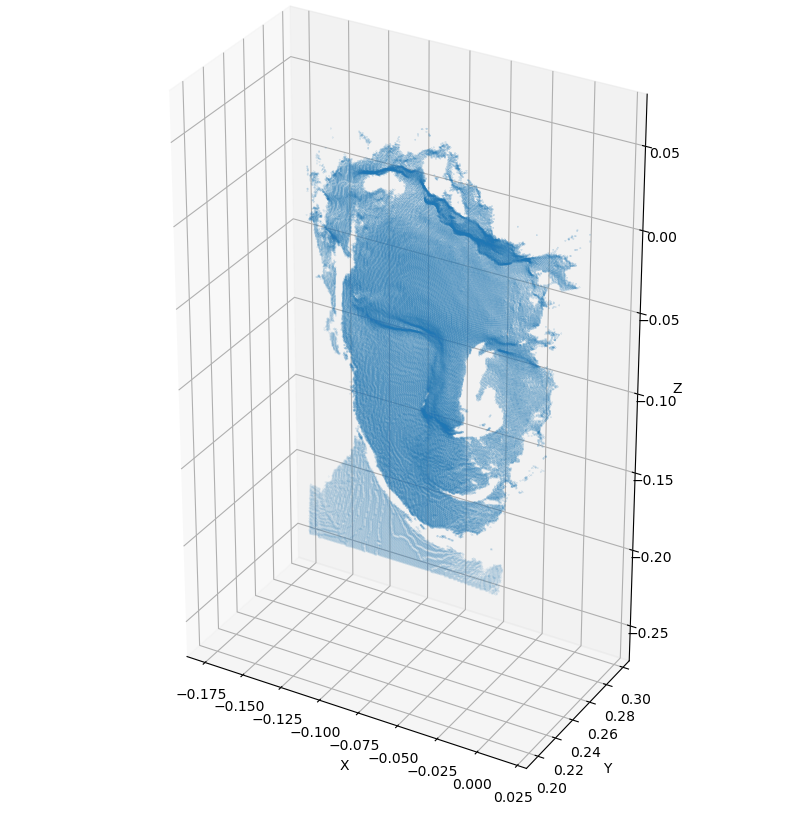

In [69]:
fig = plt.figure(figsize=(10,15))
num_plots = 1
rows, cols = 1, 1

plot_transform = np.eye(4)
plot_transform[:3, :3] = Rotation.from_euler("ZYX", [0, 0, -np.pi/2]).as_matrix()

idxs = np.random.choice([x for x in range(len(pcs))], num_plots)
print(idxs)

for i, idx in enumerate(idxs):
    pc = pcs[idx].copy()
    # (4, 4) @ (n, 4, 1)
    pc = plot_transform@pc[..., None]

    ax = fig.add_subplot(cols, rows, i + 1, projection="3d")
    ax.set_box_aspect((np.ptp(pc[:,0]), np.ptp(pc[:,1]), np.ptp(pc[:,2])))
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=0.01)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

plt.show()



## Animation
Here we're going to attempt to animate the ICP process using matplotlib which is going to be interesting to say the least

In [70]:
from copy import deepcopy

class FullAnimator:
    def __init__(self, pcs, transforms, fig, ax, plot_transform):
        self.transform_map = [(i, j) for i, (trans, pc) in enumerate(zip(transforms, pcs)) for j in range(0, trans.shape[0])]
        self.pcs = pcs
        self.transforms = transforms
        self.fig = fig
        self.ax = ax
        self.plot_transform = plot_transform
        self.transform_len = transforms[0].shape[0]

        self.targets = self.get_targets()
        self.mins = np.min(self.targets[-1], 0)
        self.maxs = np.max(self.targets[-1], 0)
        self.ptp = (np.ptp(self.targets[-1][:,0]), np.ptp(self.targets[-1][:,1]), np.ptp(self.targets[-1][:,2]))        

    def __call__(self, i):

        index, frame = self.transform_map[i]
        transform = self.transforms[index][frame]
        target = deepcopy(self.targets[index][:,:])
        source = deepcopy(self.pcs[index + 1])

        self.ax.clear()
        source = FullAnimator.down_sample(self.plot_transform@transform@source[...,None], 1E-3)
        self.ax.scatter(source[:, 0], source[:, 1], source[:, 2], s=0.03, c="k")

        self.ax.scatter(target[:, 0], target[:, 1], target[:, 2], s=0.01, c="r")
        self.ax.set_box_aspect(self.ptp)
        self.ax.set_xlim(self.mins[0], self.maxs[0])
        self.ax.set_ylim(self.mins[1], self.maxs[1])
        self.ax.set_zlim(self.mins[2], self.maxs[2])
        self.fig.suptitle(f"Frame {index + 1} ({frame}/{transforms[index].shape[0]})", fontsize=16)


    def get_targets(self, samples_per_frame=10_000):
        targets = []
        target = None
        for i, pc in enumerate(self.pcs[:self.transform_map[-1][0]+1]):
            if target is None:
                target = (self.plot_transform@pc[np.random.choice(pc.shape[0], samples_per_frame),:,None]).squeeze()
                targets.append(target[:,:])
            else:
                points = (self.plot_transform@self.transforms[i - 1][-1]@pc[np.random.choice(pc.shape[0], samples_per_frame),:,None]).squeeze()
                target = np.concatenate((target, points), 0)
                targets.append(target[:,:])

        return [FullAnimator.down_sample(t) for t in targets]

    def down_sample(t, voxel_size=2.5E-3):
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(t[:,:3])
        try:
            cloud = cloud.voxel_down_sample(2.5E-3)
        except Exception:
            pass
        return np.asarray(cloud.points)
                
    def __len__(self):
        return len(self.transform_map)


Animation length: 504


 14%|█▍        | 71/504 [00:28<03:25,  2.11it/s]

KeyboardInterrupt: 

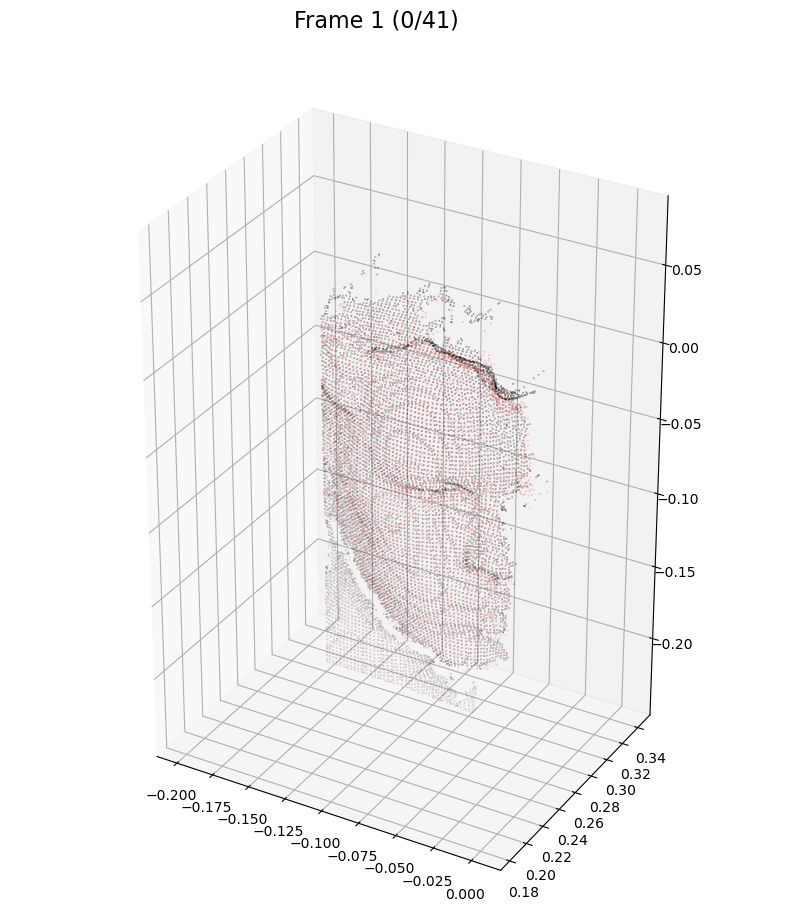

In [86]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection="3d")

plot_transform = np.eye(4)
plot_transform[:3, :3] = Rotation.from_euler("ZYX", [0, 0, -np.pi/2]).as_matrix()

animator = FullAnimator(pcs[:], [x[(0,1,2,5,10,25,38),:,:] for x in transforms], fig, ax, plot_transform)

# transforms_eye = [np.repeat(np.eye(4)[None], 5, 0) for _ in transforms]
# animator = FullAnimator(pcs[:], transforms_eye, fig, ax, plot_transform)

print(f"Animation length: {len(animator)}")

anim = animation.FuncAnimation(animator.fig, animator, len(animator))

progress_bar = tqdm(total=len(animator), position=0, leave=True)

def progress_callback(current_frame, total_frames):
    progress_bar.update(1)
    if current_frame == total_frames:
        progress_bar.close() 

anim.save(Path(f"./videos/icp_test_{time.strftime('%Y_%m_%d-%H_%M_%S')}.mp4"), fps=20, progress_callback=progress_callback)

## Check out the octtree output

In [87]:
with open(rust_path_transform / "octtree.json", "r") as infile:
    octtree = json.load(infile)

    positions, normals, counts = zip(*[(p["position"], p["normal"], p["count"]) for p in octtree])
    positions, normals, counts = np.array(positions), np.array(normals), np.array(counts)

positions.shape, normals.shape, counts.shape

((383123, 3), (383123, 3), (383123,))

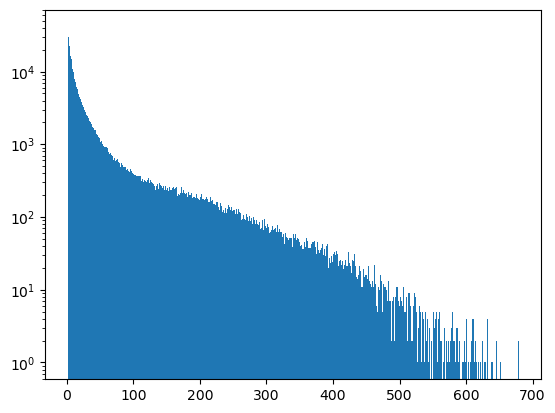

In [88]:
hist = plt.hist(counts, log=True, bins=int(np.max(counts)) - 1)

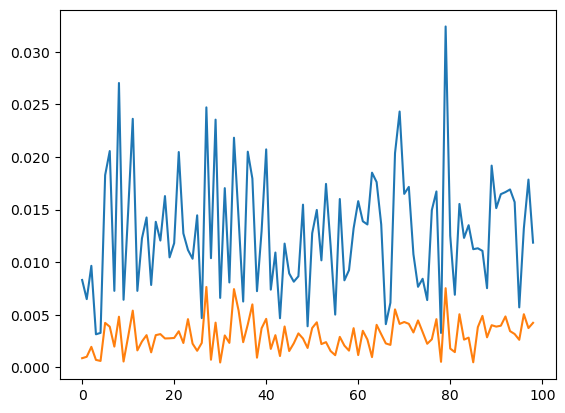

In [89]:
diff_transforms = [transforms[i + 1][-1]@np.linalg.inv(x[-1]) for i, x in enumerate(transforms[:-1])]

def extract(x: np.ndarray):
    translation = x[:3, -1]
    rotation = Rotation.from_matrix(x[:3, :3])

    return translation, rotation.as_quat(True)


def quat_to_angle(x: np.ndarray):
    # Scipy rotatation gives quaternions as x,y,z,w not w,x,y,z
    return np.arccos(x[3])*2

plt.plot(np.array([quat_to_angle(extract(f)[1]) for f in diff_transforms]))
plt.plot(np.array([np.linalg.norm(extract(f)[0]) for f in diff_transforms]))

In [90]:
octtree_pc = o3d.geometry.PointCloud()
octtree_pc.points = o3d.utility.Vector3dVector(positions[counts > 10])
octtree_pc.normals = o3d.utility.Vector3dVector(-normals[counts > 10])
# octtree_pc = octtree_pc.voxel_down_sample(25E-4)
octtree_pc.paint_uniform_color([0, 0.706, 1])
o3d.visualization.draw_geometries([octtree_pc])